# Phase 2: Advanced Techniques on ConvNext

**Trial 1: Enhanced Data Augmentation**
- RandAugment / AutoAugment
- CutMix / MixUp
- Advanced transformations

**Trial 2: Regularization & Training**
- Label smoothing (ε=0.1)
- Stochastic depth / Dropout
- Longer training (40 epochs)
- Better learning rate schedule

**Trial 3: Progressive Training**
- Start with 224x224
- Progress to 288x288 or 384x384
- Multi-scale training

**Trial 4: Ensemble Methods**
- Train multiple models with different seeds
- Test-Time Augmentation (TTA)
- Model averaging

---

## 1. Setup & Configuration

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import random
from copy import deepcopy
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import cv2
from PIL import Image

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Device: cuda
GPU: NVIDIA L4
Memory: 23.80 GB


In [ ]:
CLASS_NAMES = {
    0: 'Groove_billed_Ani', 1: 'Red_winged_Blackbird', 2: 'Rusty_Blackbird',
    3: 'Gray_Catbird', 4: 'Brandt_Cormorant', 5: 'Eastern_Towhee',
    6: 'Indigo_Bunting', 7: 'Brewer_Blackbird', 8: 'Painted_Bunting',
    9: 'Bobolink', 10: 'Lazuli_Bunting', 11: 'Yellow_headed_Blackbird',
    12: 'American_Crow', 13: 'Fish_Crow', 14: 'Brown_Creeper',
    15: 'Yellow_billed_Cuckoo', 16: 'Yellow_breasted_Chat',
    17: 'Black_billed_Cuckoo', 18: 'Gray_crowned_Rosy_Finch', 19: 'Bronzed_Cowbird'
}

NUM_CLASSES = 20

CONFIG = {
    'data_dir': '/content/drive/MyDrive/data',
    'train_csv': '/content/drive/MyDrive/data/train_metadata.csv',
    'val_csv': '/content/drive/MyDrive/data/val_metadata.csv',
    'train_images': '/content/drive/MyDrive/data/train_images',
    'val_images': '/content/drive/MyDrive/data/val_images',
    'test_images': '/content/drive/MyDrive/data/test_images',
    'sample_submission': '/content/drive/MyDrive/data/sample_submission.csv',

    # Phase 1 checkpoint
    'phase1_checkpoint_dir': '/content/drive/My Drive/ml_results/phase1_checkpoints',

    # Training params
    'img_size': 224,  # Can try 288 and 384 later
    'batch_size': 32,
    'epochs': 40,
    'lr': 5e-5,
    'weight_decay': 1e-4,
    'num_workers': 4,

    # Advanced Techniques
    'use_mixup': True,
    'mixup_alpha': 0.2,
    'use_cutmix': True,
    'cutmix_alpha': 1.0,
    'label_smoothing': 0.1,
    'drop_path_rate': 0.1,

    # Output
    'checkpoint_dir': '/content/drive/My Drive/ml_results/phase2_checkpoints',
    'results_dir': '/content/drive/My Drive/ml_results/phase2_results',
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

## 2. Advanced Data Augmentation

In [ ]:
# Dataset class
class BirdDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['path'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, row['class_idx']

In [ ]:
def get_advanced_transforms(img_size=224, mode='train'):
    """
    Advanced augmentation strategies for Phase 2
    """
    if mode == 'train':
        return A.Compose([
            # Geometric transforms
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.15,
                scale_limit=0.15,
                rotate_limit=30,
                p=0.5
            ),
            A.OneOf([
                A.Perspective(p=1),
                A.ElasticTransform(p=1),
            ], p=0.3),

            # Color transforms
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=0.3,
                    contrast_limit=0.3,
                    p=1
                ),
                A.HueSaturationValue(
                    hue_shift_limit=20,
                    sat_shift_limit=30,
                    val_shift_limit=20,
                    p=1
                ),
                A.ColorJitter(p=1),
            ], p=0.5),

            # Blur and noise
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=1),
                A.GaussNoise(var_limit=(10.0, 50.0), p=1),
                A.MotionBlur(blur_limit=5, p=1),
            ], p=0.3),

            # Dropout/cutout for regularization
            A.OneOf([
                A.CoarseDropout(
                    max_holes=8,
                    max_height=img_size//8,
                    max_width=img_size//8,
                    min_holes=1,
                    fill_value=0,
                    p=1
                ),
                A.GridDropout(ratio=0.2, p=1),
            ], p=0.3),

            # Normalize
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])

In [ ]:
# Load data
train_df = pd.read_csv(CONFIG['train_csv'])
val_df = pd.read_csv(CONFIG['val_csv'])

train_dataset = BirdDataset(
    train_df,
    CONFIG['train_images'],
    get_advanced_transforms(CONFIG['img_size'], 'train')
)

val_dataset = BirdDataset(
    val_df,
    CONFIG['val_images'],
    get_advanced_transforms(CONFIG['img_size'], 'val')
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

## 3. MixUp & CutMix Implementation

In [ ]:
def mixup_data(x, y, alpha=0.2):
    """Apply MixUp augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    """Apply CutMix augmentation"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    _, _, H, W = x.shape

    # Random box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    # Adjust lambda
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def mixed_criterion(criterion, pred, y_a, y_b, lam):
    """Loss for mixed samples"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## 4. Label Smoothing Loss

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    Label smoothing to prevent overconfidence
    """
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, target):
        n_classes = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)

        # Smooth labels
        loss = -log_preds.sum(dim=-1).mean()
        nll = F.nll_loss(log_preds, target, reduction='mean')

        return self.epsilon * loss / n_classes + (1 - self.epsilon) * nll

## 5. Model Creation

In [ ]:
def create_model(model_name='convnext_tiny', num_classes=NUM_CLASSES,
                pretrained=True, drop_path_rate=0.1):
    """
    Create ConvNeXt model with stochastic depth (drop path)
    """
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes,
        drop_path_rate=drop_path_rate  # Stochastic depth
    )
    return model

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

## 6. Advanced Training Loop

In [ ]:
def train_epoch_advanced(model, loader, criterion, optimizer, device, config):
    model.train()
    running_loss = 0.0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Randomly apply MixUp or CutMix
        r = np.random.rand()
        if config['use_mixup'] and r < 0.4:
            images, labels_a, labels_b, lam = mixup_data(
                images, labels, config['mixup_alpha']
            )
            use_mixed = True
        elif config['use_cutmix'] and r < 0.8:
            images, labels_a, labels_b, lam = cutmix_data(
                images, labels, config['cutmix_alpha']
            )
            use_mixed = True
        else:
            use_mixed = False

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # Compute loss
        if use_mixed:
            loss = mixed_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * images.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate(model, loader, criterion, device):
    """Standard validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
def train_model_advanced(model, train_loader, val_loader, experiment_name,
                        epochs=40, lr=5e-5, config=CONFIG):
    print(f"\n{'='*70}")
    print(f"PHASE 2 EXPERIMENT: {experiment_name}")
    print(f"{'='*70}")

    total_params, trainable_params = count_parameters(model)
    print(f"Parameters: {trainable_params:,} trainable / {total_params:,} total")
    print(f"MixUp: {config['use_mixup']}, CutMix: {config['use_cutmix']}")
    print(f"Label smoothing: {config['label_smoothing']}")
    print(f"Drop path rate: {config['drop_path_rate']}")

    # Setup
    model = model.to(device)

    # Label smoothing loss for training
    train_criterion = LabelSmoothingCrossEntropy(epsilon=config['label_smoothing'])
    # Standard CE for validation (to compare with Phase 1)
    val_criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=config['weight_decay']
    )

    # Cosine annealing with warmup
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs,
        eta_min=1e-6
    )

    # Tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    patience_counter = 0
    patience = 10  # Early stopping

    start_time = time.time()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train
        train_loss = train_epoch_advanced(
            model, train_loader, train_criterion, optimizer, device, config
        )

        # Validate
        val_loss, val_acc, val_preds, val_labels = validate(
            model, val_loader, val_criterion, device
        )

        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Track
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"LR: {current_lr:.6f}")

        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'config': config
            }
            torch.save(
                checkpoint,
                os.path.join(CONFIG['checkpoint_dir'], f'{experiment_name}_best.pth')
            )
            print(f"✓ Best model saved: {val_acc:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    total_time = time.time() - start_time

    print(f"\n{'='*70}")
    print(f"Training Complete!")
    print(f"Best Val Accuracy: {best_val_acc:.4f}")
    print(f"Improvement over Phase 1: {(best_val_acc - 0.9223)*100:.2f}%")
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"{'='*70}")

    return history, best_val_acc

## 7. Experiments

### Experiment 1: Full Advanced Pipeline (224x224)

In [ ]:
# Experiment 1: All techniques at 224x224
print("\n" + "#"*80)
print("EXPERIMENT 1: Full Advanced Training @ 224x224")
print("#"*80)

model_exp1 = create_model(
    'convnext_tiny',
    num_classes=NUM_CLASSES,
    pretrained=True,
    drop_path_rate=CONFIG['drop_path_rate']
)

history_exp1, best_acc_exp1 = train_model_advanced(
    model_exp1,
    train_loader,
    val_loader,
    experiment_name='convnext_advanced_224',
    epochs=CONFIG['epochs'],
    lr=CONFIG['lr'],
    config=CONFIG
)

# Clear memory
del model_exp1
torch.cuda.empty_cache()


################################################################################
EXPERIMENT 1: Full Advanced Training @ 224x224
################################################################################


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


PHASE 2 EXPERIMENT: convnext_advanced_224
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.6728
Val Loss: 0.8707, Val Acc: 0.8252
LR: 0.000050
✓ Best model saved: 0.8252

Epoch 2/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.6657
Val Loss: 0.4909, Val Acc: 0.8738
LR: 0.000050
✓ Best model saved: 0.8738

Epoch 3/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4954
Val Loss: 0.3531, Val Acc: 0.9223
LR: 0.000049
✓ Best model saved: 0.9223

Epoch 4/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5200
Val Loss: 0.3713, Val Acc: 0.9029
LR: 0.000049

Epoch 5/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5319
Val Loss: 0.4041, Val Acc: 0.8641
LR: 0.000048

Epoch 6/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3922
Val Loss: 0.3950, Val Acc: 0.9029
LR: 0.000047

Epoch 7/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3518
Val Loss: 0.3545, Val Acc: 0.8835
LR: 0.000046

Epoch 8/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2958
Val Loss: 0.3315, Val Acc: 0.9223
LR: 0.000045

Epoch 9/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2486
Val Loss: 0.2810, Val Acc: 0.9223
LR: 0.000044

Epoch 10/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2019
Val Loss: 0.3093, Val Acc: 0.9029
LR: 0.000043

Epoch 11/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1627
Val Loss: 0.2952, Val Acc: 0.9223
LR: 0.000041

Epoch 12/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.3457
Val Loss: 0.2793, Val Acc: 0.9320
LR: 0.000040
✓ Best model saved: 0.9320

Epoch 13/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2318
Val Loss: 0.2898, Val Acc: 0.9417
LR: 0.000038
✓ Best model saved: 0.9417

Epoch 14/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1460
Val Loss: 0.3276, Val Acc: 0.9223
LR: 0.000037

Epoch 15/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2393
Val Loss: 0.3624, Val Acc: 0.9223
LR: 0.000035

Epoch 16/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1461
Val Loss: 0.3775, Val Acc: 0.8835
LR: 0.000033

Epoch 17/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0448
Val Loss: 0.3477, Val Acc: 0.8932
LR: 0.000031

Epoch 18/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1138
Val Loss: 0.3630, Val Acc: 0.9126
LR: 0.000029

Epoch 19/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2903
Val Loss: 0.2812, Val Acc: 0.9417
LR: 0.000027

Epoch 20/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0549
Val Loss: 0.3248, Val Acc: 0.9320
LR: 0.000025

Epoch 21/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1752
Val Loss: 0.3433, Val Acc: 0.9223
LR: 0.000024

Epoch 22/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0107
Val Loss: 0.3420, Val Acc: 0.9223
LR: 0.000022

Epoch 23/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1808
Val Loss: 0.2848, Val Acc: 0.9320
LR: 0.000020

Early stopping at epoch 23

Training Complete!
Best Val Accuracy: 0.9417
Improvement over Phase 1: 1.94%
Total Time: 16.32 minutes


### Experiment 2: Progressive Training (224 → 288)

In [ ]:
# Experiment 2: Progressive resizing
print("\n" + "#"*80)
print("EXPERIMENT 2: Progressive Training 224 → 288")
print("#"*80)

# Stage 1: Train at 224
print("\nStage 1: Training at 224x224 (20 epochs)...")
model_exp2 = create_model(
    'convnext_tiny',
    num_classes=NUM_CLASSES,
    pretrained=True,
    drop_path_rate=CONFIG['drop_path_rate']
)

config_stage1 = CONFIG.copy()
config_stage1['img_size'] = 224

history_stage1, _ = train_model_advanced(
    model_exp2,
    train_loader,
    val_loader,
    experiment_name='convnext_progressive_stage1',
    epochs=20,
    lr=CONFIG['lr'],
    config=config_stage1
)

# Stage 2: Continue at 288
print("\nStage 2: Continuing at 288x288 (20 epochs)...")

# Create new dataloaders at 288
train_dataset_288 = BirdDataset(
    train_df,
    CONFIG['train_images'],
    get_advanced_transforms(288, 'train')
)

val_dataset_288 = BirdDataset(
    val_df,
    CONFIG['val_images'],
    get_advanced_transforms(288, 'val')
)

train_loader_288 = DataLoader(
    train_dataset_288,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader_288 = DataLoader(
    val_dataset_288,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

config_stage2 = CONFIG.copy()
config_stage2['img_size'] = 288

history_stage2, best_acc_exp2 = train_model_advanced(
    model_exp2,
    train_loader_288,
    val_loader_288,
    experiment_name='convnext_progressive_288',
    epochs=20,
    lr=CONFIG['lr'] / 2,  # Lower LR for fine-tuning
    config=config_stage2
)

# Clear memory
del model_exp2, train_loader_288, val_loader_288
torch.cuda.empty_cache()


################################################################################
EXPERIMENT 2: Progressive Training 224 → 288
################################################################################

Stage 1: Training at 224x224 (20 epochs)...

PHASE 2 EXPERIMENT: convnext_progressive_stage1
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.5059
Val Loss: 0.7811, Val Acc: 0.7864
LR: 0.000050
✓ Best model saved: 0.7864

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.8077
Val Loss: 0.5117, Val Acc: 0.8350
LR: 0.000049
✓ Best model saved: 0.8350

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5790
Val Loss: 0.4307, Val Acc: 0.8738
LR: 0.000047
✓ Best model saved: 0.8738

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3239
Val Loss: 0.3469, Val Acc: 0.9126
LR: 0.000045
✓ Best model saved: 0.9126

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3793
Val Loss: 0.3523, Val Acc: 0.9029
LR: 0.000043

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3687
Val Loss: 0.3429, Val Acc: 0.9126
LR: 0.000040

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3037
Val Loss: 0.3216, Val Acc: 0.9223
LR: 0.000037
✓ Best model saved: 0.9223

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2962
Val Loss: 0.3359, Val Acc: 0.8932
LR: 0.000033

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2515
Val Loss: 0.2701, Val Acc: 0.8932
LR: 0.000029

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.3288
Val Loss: 0.3053, Val Acc: 0.9029
LR: 0.000025

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2481
Val Loss: 0.2930, Val Acc: 0.9320
LR: 0.000022
✓ Best model saved: 0.9320

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1897
Val Loss: 0.3169, Val Acc: 0.9320
LR: 0.000018

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0732
Val Loss: 0.2913, Val Acc: 0.9126
LR: 0.000014

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1632
Val Loss: 0.2926, Val Acc: 0.9126
LR: 0.000011

Epoch 15/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0090
Val Loss: 0.2926, Val Acc: 0.9320
LR: 0.000008

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0585
Val Loss: 0.2738, Val Acc: 0.9320
LR: 0.000006

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0872
Val Loss: 0.2686, Val Acc: 0.9320
LR: 0.000004

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1612
Val Loss: 0.2664, Val Acc: 0.9223
LR: 0.000002

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2169
Val Loss: 0.2637, Val Acc: 0.9223
LR: 0.000001

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1549
Val Loss: 0.2664, Val Acc: 0.9223
LR: 0.000001

Training Complete!
Best Val Accuracy: 0.9320
Improvement over Phase 1: 0.97%
Total Time: 12.67 minutes

Stage 2: Continuing at 288x288 (20 epochs)...

PHASE 2 EXPERIMENT: convnext_progressive_288
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9937
Val Loss: 0.3157, Val Acc: 0.9223
LR: 0.000025
✓ Best model saved: 0.9223

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1874
Val Loss: 0.2477, Val Acc: 0.9417
LR: 0.000024
✓ Best model saved: 0.9417

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1651
Val Loss: 0.3030, Val Acc: 0.9223
LR: 0.000024

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.2075
Val Loss: 0.2985, Val Acc: 0.9320
LR: 0.000023

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1466
Val Loss: 0.3280, Val Acc: 0.9320
LR: 0.000021

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1570
Val Loss: 0.3025, Val Acc: 0.9417
LR: 0.000020

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0803
Val Loss: 0.3124, Val Acc: 0.9417
LR: 0.000018

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1984
Val Loss: 0.2818, Val Acc: 0.9320
LR: 0.000017

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0191
Val Loss: 0.2729, Val Acc: 0.9320
LR: 0.000015

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0691
Val Loss: 0.2878, Val Acc: 0.9223
LR: 0.000013

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1004
Val Loss: 0.2702, Val Acc: 0.9417
LR: 0.000011

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1211
Val Loss: 0.2664, Val Acc: 0.9417
LR: 0.000009

Early stopping at epoch 12

Training Complete!
Best Val Accuracy: 0.9417
Improvement over Phase 1: 1.94%
Total Time: 6.28 minutes


### Experiment 3: Ensemble Training (Multiple Seeds)

In [ ]:
# Experiment 3: Train 3 models with different seeds for ensemble
print("\n" + "#"*80)
print("EXPERIMENT 3: Ensemble Training (3 models)")
print("#"*80)

ensemble_results = []
seeds = [42, 123, 777]

for i, seed in enumerate(seeds, 1):
    print(f"\n{'='*50}")
    print(f"Training Ensemble Model {i}/3 (seed={seed})")
    print(f"{'='*50}")

    set_seed(seed)

    model = create_model(
        'convnext_tiny',
        num_classes=NUM_CLASSES,
        pretrained=True,
        drop_path_rate=CONFIG['drop_path_rate']
    )

    history, best_acc = train_model_advanced(
        model,
        train_loader,
        val_loader,
        experiment_name=f'convnext_ensemble_{i}_seed{seed}',
        epochs=30,  # Slightly fewer epochs per model
        lr=CONFIG['lr'],
        config=CONFIG
    )

    ensemble_results.append({
        'seed': seed,
        'best_acc': best_acc,
        'history': history
    })

    del model
    torch.cuda.empty_cache()

print("\n" + "="*70)
print("Ensemble Training Complete!")
for i, result in enumerate(ensemble_results, 1):
    print(f"Model {i} (seed={result['seed']}): {result['best_acc']:.4f}")
print(f"Mean accuracy: {np.mean([r['best_acc'] for r in ensemble_results]):.4f}")
print("="*70)


################################################################################
EXPERIMENT 3: Ensemble Training (3 models)
################################################################################

Training Ensemble Model 1/3 (seed=42)

PHASE 2 EXPERIMENT: convnext_ensemble_1_seed42
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.6728
Val Loss: 0.8707, Val Acc: 0.8252
LR: 0.000050
✓ Best model saved: 0.8252

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.6656
Val Loss: 0.4905, Val Acc: 0.8738
LR: 0.000049
✓ Best model saved: 0.8738

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4951
Val Loss: 0.3531, Val Acc: 0.9223
LR: 0.000049
✓ Best model saved: 0.9223

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.5195
Val Loss: 0.3717, Val Acc: 0.9029
LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5312
Val Loss: 0.4008, Val Acc: 0.8641
LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3902
Val Loss: 0.3929, Val Acc: 0.9029
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3481
Val Loss: 0.3529, Val Acc: 0.8835
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2895
Val Loss: 0.3233, Val Acc: 0.9223
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2460
Val Loss: 0.2872, Val Acc: 0.9320
LR: 0.000040
✓ Best model saved: 0.9320

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1972
Val Loss: 0.3181, Val Acc: 0.9126
LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1546
Val Loss: 0.2872, Val Acc: 0.9417
LR: 0.000035
✓ Best model saved: 0.9417

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3435
Val Loss: 0.2736, Val Acc: 0.9417
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2098
Val Loss: 0.2848, Val Acc: 0.9417
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1288
Val Loss: 0.3273, Val Acc: 0.9223
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2233
Val Loss: 0.3086, Val Acc: 0.9320
LR: 0.000026

Epoch 16/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.1359
Val Loss: 0.3402, Val Acc: 0.9029
LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0304
Val Loss: 0.3383, Val Acc: 0.9320
LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1092
Val Loss: 0.3091, Val Acc: 0.9417
LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2785
Val Loss: 0.2754, Val Acc: 0.9515
LR: 0.000016
✓ Best model saved: 0.9515

Epoch 20/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0481
Val Loss: 0.2758, Val Acc: 0.9515
LR: 0.000013

Epoch 21/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1587
Val Loss: 0.2901, Val Acc: 0.9320
LR: 0.000011

Epoch 22/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0045
Val Loss: 0.3072, Val Acc: 0.9320
LR: 0.000009

Epoch 23/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1757
Val Loss: 0.2688, Val Acc: 0.9515
LR: 0.000007

Epoch 24/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>^
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1203
Val Loss: 0.2577, Val Acc: 0.9612
LR: 0.000006
✓ Best model saved: 0.9612

Epoch 25/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2164
Val Loss: 0.2924, Val Acc: 0.9223
LR: 0.000004

Epoch 26/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1327
Val Loss: 0.2637, Val Acc: 0.9320
LR: 0.000003

Epoch 27/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9743
Val Loss: 0.2782, Val Acc: 0.9320
LR: 0.000002

Epoch 28/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0580
Val Loss: 0.2605, Val Acc: 0.9320
LR: 0.000002

Epoch 29/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0945
Val Loss: 0.2665, Val Acc: 0.9320
LR: 0.000001

Epoch 30/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0869
Val Loss: 0.2652, Val Acc: 0.9320
LR: 0.000001

Training Complete!
Best Val Accuracy: 0.9612
Improvement over Phase 1: 3.89%
Total Time: 16.86 minutes

Training Ensemble Model 2/3 (seed=123)

PHASE 2 EXPERIMENT: convnext_ensemble_2_seed123
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.7383
Val Loss: 1.0719, Val Acc: 0.7767
LR: 0.000050
✓ Best model saved: 0.7767

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.7937
Val Loss: 0.5303, Val Acc: 0.8738
LR: 0.000049
✓ Best model saved: 0.8738

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5299
Val Loss: 0.4376, Val Acc: 0.8932
LR: 0.000049
✓ Best model saved: 0.8932

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4582
Val Loss: 0.3801, Val Acc: 0.8738
LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3461
Val Loss: 0.3006, Val Acc: 0.9223
LR: 0.000047
✓ Best model saved: 0.9223

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4554
Val Loss: 0.3583, Val Acc: 0.9126
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4264
Val Loss: 0.3812, Val Acc: 0.9029
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3518
Val Loss: 0.3628, Val Acc: 0.9223
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2587
Val Loss: 0.3472, Val Acc: 0.9126
LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>Exception ignored in:     se

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2773
Val Loss: 0.2927, Val Acc: 0.9223
LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2903
Val Loss: 0.3086, Val Acc: 0.9029
LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3017
Val Loss: 0.3292, Val Acc: 0.9126
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1464
Val Loss: 0.3197, Val Acc: 0.9223
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

          File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():self._sh

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2123
Val Loss: 0.2853, Val Acc: 0.9223
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2991
Val Loss: 0.2907, Val Acc: 0.9223
LR: 0.000026

Early stopping at epoch 15

Training Complete!
Best Val Accuracy: 0.9223
Improvement over Phase 1: 0.00%
Total Time: 6.45 minutes

Training Ensemble Model 3/3 (seed=777)

PHASE 2 EXPERIMENT: convnext_ensemble_3_seed777
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Training:   0%|          | 0/34 [00:01<?, ?it/s]

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^ ^ ^ ^ ^ ^ ^ ^^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^: ^can only test a child process^
^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.6486
Val Loss: 0.9098, Val Acc: 0.7961
LR: 0.000050
✓ Best model saved: 0.7961

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.9038
Val Loss: 0.5239, Val Acc: 0.8544
LR: 0.000049
✓ Best model saved: 0.8544

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5961
Val Loss: 0.4525, Val Acc: 0.8544
LR: 0.000049

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4778
Val Loss: 0.3568, Val Acc: 0.9029
LR: 0.000048
✓ Best model saved: 0.9029

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3191
Val Loss: 0.4260, Val Acc: 0.8738
LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3634
Val Loss: 0.3835, Val Acc: 0.8835
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2807
Val Loss: 0.3373, Val Acc: 0.9029
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3199
Val Loss: 0.3289, Val Acc: 0.9029
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [01:20<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3239
Val Loss: 0.3600, Val Acc: 0.9126
LR: 0.000038
✓ Best model saved: 0.9126

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2659
Val Loss: 0.2905, Val Acc: 0.9126
LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1357
Val Loss: 0.3544, Val Acc: 0.8932
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: 

Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30
Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30
Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30


<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>

Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python

Train Loss: 1.2484
Val Loss: 0.3922, Val Acc: 0.8932
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3112
Val Loss: 0.3422, Val Acc: 0.9029
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2277
Val Loss: 0.2719, Val Acc: 0.9320
LR: 0.000026
✓ Best model saved: 0.9320

Epoch 16/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1919
Val Loss: 0.2781, Val Acc: 0.9417
LR: 0.000023
✓ Best model saved: 0.9417

Epoch 17/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2231
Val Loss: 0.2739, Val Acc: 0.9417
LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0693
Val Loss: 0.2951, Val Acc: 0.9417
LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1163
Val Loss: 0.2991, Val Acc: 0.9515
LR: 0.000016
✓ Best model saved: 0.9515

Epoch 20/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2064
Val Loss: 0.2829, Val Acc: 0.9320
LR: 0.000013

Epoch 21/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0752
Val Loss: 0.2651, Val Acc: 0.9515
LR: 0.000011

Epoch 22/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1724
Val Loss: 0.3101, Val Acc: 0.9223
LR: 0.000009

Epoch 23/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1344
Val Loss: 0.2870, Val Acc: 0.9223
LR: 0.000007

Epoch 24/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.0155
Val Loss: 0.2865, Val Acc: 0.9126
LR: 0.000006

Epoch 25/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2125
Val Loss: 0.2886, Val Acc: 0.9126
LR: 0.000004

Epoch 26/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9277
Val Loss: 0.2805, Val Acc: 0.9223
LR: 0.000003

Epoch 27/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0386
Val Loss: 0.2835, Val Acc: 0.9320
LR: 0.000002

Epoch 28/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1449
Val Loss: 0.2900, Val Acc: 0.9029
LR: 0.000002

Epoch 29/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0531
Val Loss: 0.2909, Val Acc: 0.9223
LR: 0.000001

Early stopping at epoch 29

Training Complete!
Best Val Accuracy: 0.9515
Improvement over Phase 1: 2.92%
Total Time: 25.25 minutes

Ensemble Training Complete!
Model 1 (seed=42): 0.9612
Model 2 (seed=123): 0.9223
Model 3 (seed=777): 0.9515
Mean accuracy: 0.9450


## 8. Phase 2 Results Analysis

In [ ]:
phase2_results = pd.DataFrame([
    {
        'Experiment': 'Phase 1 Baseline',
        'Accuracy': 0.9223,
        'Description': 'ConvNeXt-Tiny, basic aug'
    },
    {
        'Experiment': 'Exp 1: Advanced Training',
        'Accuracy': best_acc_exp1,
        'Description': 'MixUp + CutMix + Label Smoothing @ 224'
    },
    {
        'Experiment': 'Exp 2: Progressive',
        'Accuracy': best_acc_exp2,
        'Description': '224→288 progressive training'
    },
    {
        'Experiment': 'Exp 3: Ensemble (avg)',
        'Accuracy': np.mean([r['best_acc'] for r in ensemble_results]),
        'Description': 'Mean of 3 models (different seeds)'
    },
])

phase2_results = phase2_results.sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("PHASE 2 RESULTS SUMMARY")
print("="*80)
display(phase2_results)

phase2_results.to_csv(
    os.path.join(CONFIG['results_dir'], 'phase2_results.csv'),
    index=False
)
print("\n✓ Results saved")


PHASE 2 RESULTS SUMMARY


,Experiment,Accuracy,Description
3,Exp 3: Ensemble (avg),0.944984,Mean of 3 models (different seeds)
1,Exp 1: Advanced Training,0.941748,MixUp + CutMix + Label Smoothing @ 224
2,Exp 2: Progressive,0.941748,224→288 progressive training
0,Phase 1 Baseline,0.922300,"ConvNeXt-Tiny, basic aug"



✓ Results saved


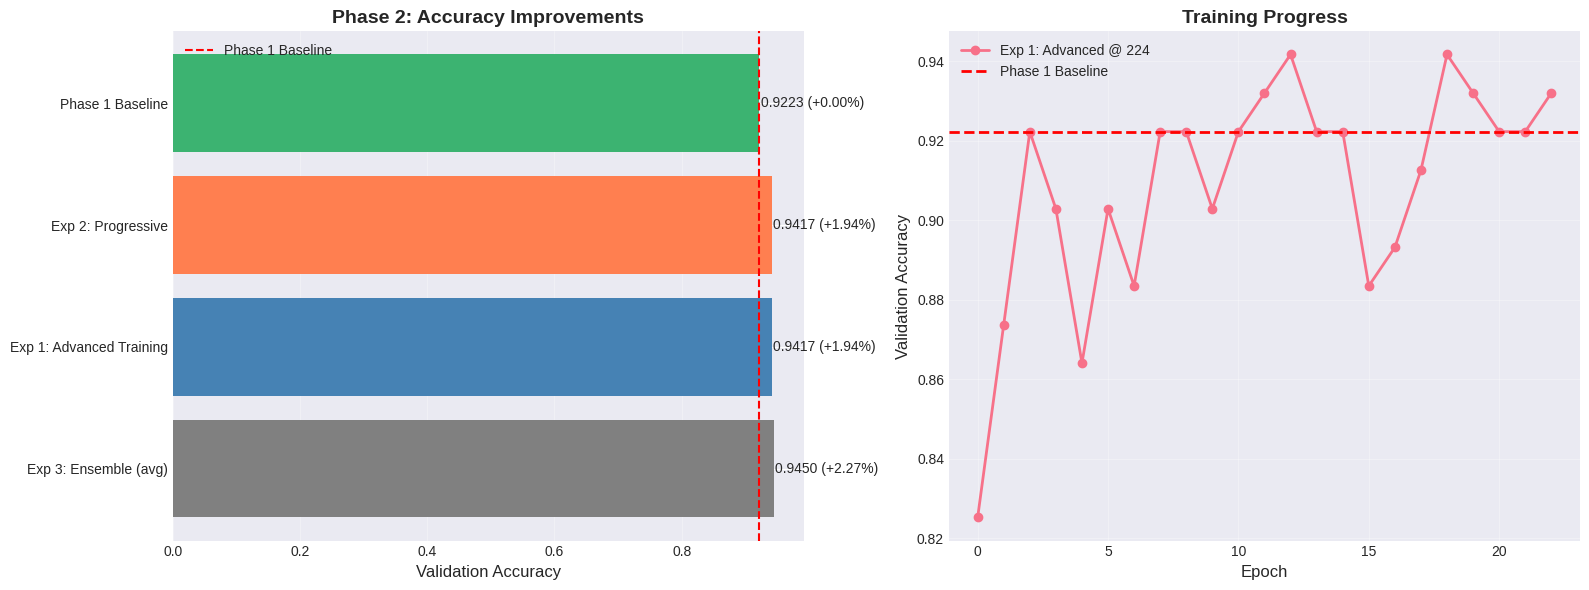

✓ Visualization saved


In [ ]:
# Visualize improvements
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
experiments = phase2_results['Experiment'].values
accuracies = phase2_results['Accuracy'].values
colors = ['gray'] + ['steelblue', 'coral', 'mediumseagreen']

axes[0].barh(experiments, accuracies, color=colors)
axes[0].set_xlabel('Validation Accuracy', fontsize=12)
axes[0].set_title('Phase 2: Accuracy Improvements', fontsize=14, fontweight='bold')
axes[0].axvline(0.9223, color='red', linestyle='--', label='Phase 1 Baseline')
axes[0].grid(axis='x', alpha=0.3)
axes[0].legend()

for i, v in enumerate(accuracies):
    improvement = (v - 0.9223) * 100
    axes[0].text(v + 0.002, i, f'{v:.4f} (+{improvement:.2f}%)', va='center')

# Training curves comparison
axes[1].plot(history_exp1['val_acc'], label='Exp 1: Advanced @ 224', marker='o', linewidth=2)
axes[1].axhline(0.9223, color='red', linestyle='--', label='Phase 1 Baseline', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].set_title('Training Progress', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(CONFIG['results_dir'], 'phase2_improvements.png'),
    dpi=150, bbox_inches='tight'
)
plt.show()

print('✓ Visualization saved')

## 9. Ensemble Prediction with Test-Time Augmentation

In [ ]:
def predict_with_tta(model, image, n_tta=5):
    """
    Test-time augmentation for better predictions
    """
    model.eval()

    # TTA transforms
    tta_transforms = [
        get_advanced_transforms(CONFIG['img_size'], 'val'),  # Original
        A.Compose([A.HorizontalFlip(p=1.0)] +
                 get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=10, p=1.0)] +
                 get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=-10, p=1.0)] +
                 get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.RandomBrightnessContrast(p=1.0)] +
                 get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
    ]

    predictions = []

    with torch.no_grad():
        for transform in tta_transforms[:n_tta]:
            augmented = transform(image=image)['image']
            augmented = augmented.unsqueeze(0).to(device)

            output = model(augmented)
            probs = F.softmax(output, dim=1)
            predictions.append(probs.cpu().numpy())

    # Average predictions
    avg_pred = np.mean(predictions, axis=0)
    return avg_pred

✓ TTA function defined


In [ ]:
# Load best model from Phase 2
best_model_name = 'convnext_ensemble_1_seed42'  # Change based on best experiment

print(f"Loading best Phase 2 model: {best_model_name}")

model = create_model(
    'convnext_tiny',
    num_classes=NUM_CLASSES,
    pretrained=False,
    drop_path_rate=0  # No dropout for inference
)

checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], f'{best_model_name}_best.pth')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

Loading best Phase 2 model: convnext_ensemble_1_seed42
✓ Model loaded (Val Acc: 0.9612)


Transform ready: True
Found 400 test images
Running TTA predictions...


  0%|          | 0/400 [00:00<?, ?it/s]

✓ Saved /content/drive/My Drive/ml_results/phase2_results/submission_phase2_convnext_ensemble_1_seed42_tta.csv
Predictions: 400
0     23
1     14
2     23
3     22
4     21
5     19
6     15
7     19
8     15
9     25
10    19
11    19
12    14
13    24
14    21
15    29
16    23
17    19
18    18
19    18
Name: count, dtype: int64


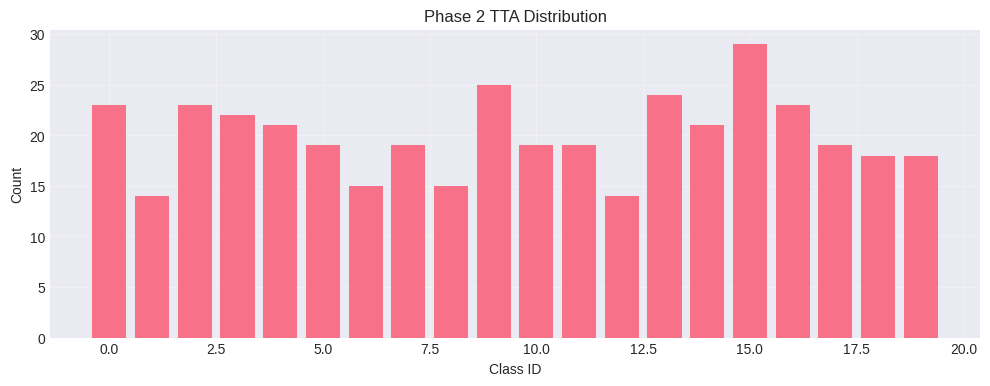

In [ ]:
test_transform = get_advanced_transforms(CONFIG['img_size'], 'val')
print(f"Transform ready: {test_transform is not None}")

test_image_paths = []
for root, dirs, files in os.walk(CONFIG['test_images']):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_image_paths.append(os.path.join(root, file))

print(f"Found {len(test_image_paths)} test images")

# Generate predictions
predictions = []
print("Running TTA predictions...")

for img_path in tqdm(test_image_paths):
    # Safe loading matching your original
    image = cv2.imread(img_path)
    if image is None or image.size == 0:
        image = np.zeros((CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    avg_pred = predict_with_tta(model, image, n_tta=5)
    predictions.append(int(np.argmax(avg_pred)))

# Save submission
submission = pd.DataFrame({
    'path': [os.path.basename(p) for p in test_image_paths],
    'class_idx': predictions
})

submission_path = os.path.join(CONFIG['results_dir'], f'submission_phase2_{best_model_name}_tta.csv')
submission.to_csv(submission_path, index=False)

print(f"✓ Saved {submission_path}")
print(f"Predictions: {len(predictions)}")
print(pd.Series(predictions).value_counts().sort_index())

# 5. Plot
plt.figure(figsize=(12, 4))
plt.bar(pd.Series(predictions).value_counts().sort_index().index,
        pd.Series(predictions).value_counts().sort_index().values)
plt.title('Phase 2 TTA Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase2_tta_dist.png'), dpi=150)
plt.show()
